In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from functools import reduce
import pylab as plt

from scipy import stats
from statannot import add_stat_annotation

from importlib import reload
import itertools
from itertools import count

import itertools, collections
import datetime

import sys

sys.path.insert(1,'../../resources')
import phenotypesnew as pheno_info

sys.path.insert(1,'../../resources/utils')
import _preprocess

/scratch/c.c21013066/data/ukbiobank/codings
/scratch/c.c21013066/data/ukbiobank/codings


In [3]:
data_path = '/scratch/c.c21013066/data/ukbiobank'

# Get data
- subset of diseased people with date and age of diagnosis
- all people with date of birth

In [2]:
def float_to_datetime(age,birth):
    year = int(age)
    rem = age - year
    base = birth + pd.offsets.DateOffset(years=year)
    result = base + datetime.timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)
    return result

In [4]:
# get data of diseased
reload(_preprocess)
name = 'ParkinsonDisease'
selfname = 'ParkinsonDisease'
gpname = 'gp_ParkinsonDisease'
drop_healthy = 'neurology'

df = pd.read_csv(f'{data_path}/sample/withGP/noOsteo/{name}.csv').set_index('eid')
print(df.shape)
df = _preprocess.date_to_datetime(df)
df = _preprocess.date_to_datetime_end(df)
df['PrevalentIncident'] = np.nan
df[f'icd10_{name}_hospital_age'] = (df[f'icd10_{name}_hospital_date'] - df['date_birth']) / np.timedelta64(1,'Y')
df[f'icd10_{name}_death_age'] = (df[f'icd10_{name}_death_date'] - df['date_birth']) / np.timedelta64(1,'Y')
#df.loc[df['ParkinsonDisease_age']<0,'ParkinsonDisease_age'] = df.filter(regex="_age")[df.filter(regex='_age')>0].min(axis=1)
df.loc[df[f'{name}_prevalent']==1,'PrevalentIncident'] = 'prevalent'
df.loc[df[f'{name}_incident']==1,'PrevalentIncident'] = 'incident'
for source in ['death','hospital','selfreported','primarycare']:
    df[f'{name}_{source}'] = df[f'{name}_{source}'].replace([0,1,np.nan],['',source,np.nan])
df['source'] = df[[f'{name}_death',f'{name}_hospital',f'{name}_selfreported',f'{name}_primarycare']].apply(lambda x: ''.join(x.dropna().astype(str)),
                                                                     axis=1)
df['final_source'] = df[[f'icd10_{name}_hospital_age',f'icd10_{name}_death_age',f'icd9_{name}_age',f'{selfname}_age',f'{gpname}_age']].idxmin(axis='columns')
df['final_source'] = df['final_source'].replace([f'icd10_{name}_hospital_age',f'icd10_{name}_death_age',f'icd9_{name}_age',f'{selfname}_age',f'{gpname}_age'],
                                               ['hospital','death','hospital','selfreport','primarycare'])
#df.loc[df[f'selfreported_{selfname}_age']<18,f'selfreported_{selfname}_age'] = np.nan
#df.loc[df[f'{name}_age']<18,f'{name}_age'] = df.loc[df[f'{name}_age']<18,[f'icd10_{name}_age',f'icd9_{name}_age']].min(axis=1)
df['time_to_diagnosis'] = df[f'{name}_age'] - df['visit_age']

df[f'selfreported_{name}_date'] = np.nan
selfre = df[~df[f'selfreported_{name}_age'].isna()]
df.loc[selfre.index,f'selfreported_{name}_date'] = selfre.apply(lambda x: float_to_datetime(x[f'selfreported_{name}_age'],x['date_birth']),axis=1)
df[f'selfreported_{name}_date'] = pd.to_datetime(df[f'selfreported_{name}_date'])

# derive date of diagnosis
df[f'{name}_date'] = df.filter(regex=f'.*{name}.*_date')[(df.filter(regex=f'.*{name}.*_date') - df[['date_birth']].values) > np.timedelta64(1,'m')].min(axis=1)

(3837, 47)


In [5]:
# get data of complete cohort
whole = pd.read_csv(f'{data_path}/phenotypes/demographics.csv',usecols=['eid','male','date_birth'],parse_dates=['date_birth']).set_index('eid')
death = pd.read_csv(f'{data_path}/phenotypes/death.csv',parse_dates=['death_date']).set_index('eid')
whole = pd.merge(whole,death,right_index=True,left_index=True,how='outer')

# Incidence and Prevalence
Normally incidence is defined as new cases during time interval and prevalence as number of cases at a specific time point. We look at specific age groups and want to know the age of diagnosis and the proportion of people getting a diagnosis at specific ages/during their lifetime. In UKBB we follow one age group over time, hence the size of the age groups develope periodically and groups disappear. We decide to look at the time intervals where everyone is the same age instead of monitoring the development over consecutive years. Meaning that we check how many get a diagnosis while they are age 30-39, 40-49 etc and how many already have a diagnosis when they are 30-39, 40-49 etc. Incidence rate could be a measure of how many more cases we can expect in the next years of follow-up.
- age over years
- who reaches which age group
- at what age do people get diagnosis (incidence)
- how many people have diagnosis at specific age ranges (prevalence)

In [6]:
ageranges = ['30-39','40-49','50-59','60-69','70-79','80-89']
agebins = pd.interval_range(start=30, end=90,freq=10,closed='left')

df[f'{name}_agegroup'] = pd.cut(df[f'{name}_age'], agebins)
# four not in age-group as too young at date of diagnosis
df.loc[df[f'{name}_agegroup'].isna(),f'{name}_age']

df[f'{name}_agegroup_rounded'] = pd.cut(df[f'{name}_age'].round(), agebins)
# four not in age-group as too young at date of diagnosis
df.loc[df[f'{name}_agegroup_rounded'].isna(),f'{name}_age']

eid
1918908          NaN
1984240    28.008789
4949020     7.819462
5149342    25.462535
5745288    17.747113
Name: ParkinsonDisease_age, dtype: float64

In [7]:
# only have data up until March 2021, so only show until 2020
df[f'{name}_date'].max()

Timestamp('2021-03-11 00:00:00')

In [8]:
# one with problematic date not available, remove from cohort for now
print(df[df[f'{name}_age'].isna()].filter(regex='date'))
remove = df[df[f'{name}_age'].isna()].index
df = df.drop(index=remove)
whole = whole.drop(index=remove)

        icd10_ParkinsonDisease_death_date  \
eid                                         
1918908                               NaT   

        icd10_ParkinsonDisease_hospital_date  \
eid                                            
1918908                                  NaT   

        icd9_ParkinsonDisease_hospital_date date_visit  \
eid                                                      
1918908                                 NaT 2010-02-27   

        gp_ParkinsonDisease_date date_birth  \
eid                                           
1918908                      NaT 1959-06-15   

        selfreported_ParkinsonDisease_date ParkinsonDisease_date  
eid                                                               
1918908                                NaT                   NaT  


In [9]:
# merge whole and df
whole = pd.merge(whole,df[[f'{name}_age',f'{name}_date']],right_index=True,left_index=True,how='outer')

In [10]:
start = df[f'{name}_date'].min().year
end = df[f'{name}_date'].max().year

ages_whole = pd.DataFrame(index=whole.index,columns=pd.date_range(start=f'1/1/{start}', periods=63,freq='1Y').tolist())
ages_whole.iloc[:,0] = (ages_whole.columns[0] - whole['date_birth']) / np.timedelta64(1,'Y')
ages_whole.iloc[:,1:] = 1
ages_ = ages_whole.cumsum(axis=1)
age_groups_whole = ages_.apply(lambda x: pd.cut(x,agebins))
age_group_dist_whole = age_groups_whole.apply(pd.value_counts)
age_group_dist_whole.index = age_group_dist_whole.index.rename(f'{name}_agegroup')
age_group_dist_whole = pd.melt(age_group_dist_whole.reset_index(),id_vars=f'{name}_agegroup',var_name=f'{name}_date',value_name='N')

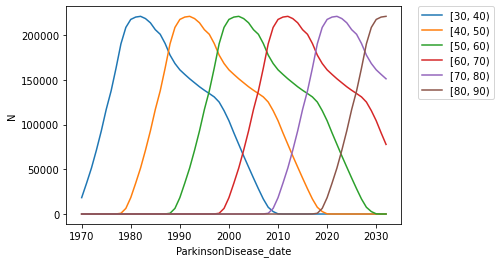

In [11]:
# problem when scaling by age group proportion: ukbb follows one age group
sns.lineplot(x=f'{name}_date',y='N',hue=f'{name}_agegroup',data =age_group_dist_whole)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [12]:
# remove people from data when dead
# instead of age go with year, so at end of year check which age-group and whether diagnosed
dead_N = age_groups_whole.loc[~whole['death_date'].isna()]
start_death = whole['death_date']
print(age_groups_whole.isna().sum())
# retain only age group when not dead
for year in age_groups_whole.columns:
    age_groups_whole.loc[start_death.apply(lambda x: x.year)<=year.year,year] = np.nan
print(age_groups_whole.isna().sum())
age_group_dist_whole = age_groups_whole.apply(pd.value_counts)
age_group_dist_whole.index = age_group_dist_whole.index.rename(f'{name}_agegroup')
age_group_dist_whole = pd.melt(age_group_dist_whole.reset_index(),id_vars=f'{name}_agegroup',var_name=f'{name}_date',value_name='N')

1969-12-31    484077
1970-12-31    467869
1971-12-31    450833
1972-12-31    430894
1973-12-31    409321
               ...  
2027-12-31       808
2028-12-31      6274
2029-12-31     18335
2030-12-31     34543
2031-12-31     51579
Length: 63, dtype: int64
1969-12-31    484077
1970-12-31    467869
1971-12-31    450833
1972-12-31    430894
1973-12-31    409321
               ...  
2027-12-31     35626
2028-12-31     39850
2029-12-31     49621
2030-12-31     63145
2031-12-31     77564
Length: 63, dtype: int64


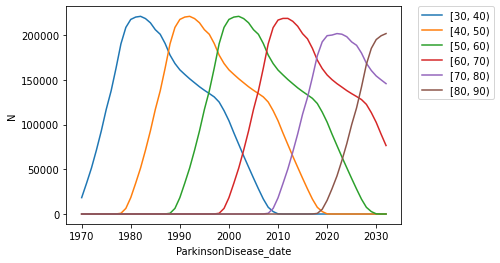

In [13]:
# problem when scaling by age group proportion: ukbb follows one age group
sns.lineplot(x=f'{name}_date',y='N',hue=f'{name}_agegroup',data =age_group_dist_whole)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [14]:
# count which ages are how often in dataset
unique = age_groups_whole.iloc[:,:-11].apply(lambda x: list(set(x)), axis = 1)
counter = collections.Counter(itertools.chain(*list(unique.values)))

In [15]:
# count which ages are how often in dataset
unique_all = age_groups_whole.apply(lambda x: list(set(x)), axis = 1)
counter_all = collections.Counter(itertools.chain(*list(unique.values)))

## Incidence

In [34]:
# get increase in cases per year
df_y = df.reset_index().set_index(f'{name}_date')
#df.groupby(pd.Grouper(freq='Y'))[f'{name}_age'].agg(['size','mean'])
incidence = df_y.groupby([pd.Grouper(freq='Y'),f'{name}_agegroup'])[f'{name}_age'].agg(['size','mean'])

In [57]:
# instead of age go with year, so at end of year check which age-group and whether diagnosed
# instead check for each agegroup how many get a diagnosis
incidence_age = incidence_norm.groupby(f'{name}_agegroup').sum()
incidence_age['N'] = pd.DataFrame.from_dict(counter,orient='index').loc[agebins]
diseased_N = age_groups_whole.loc[df.index].iloc[:,:-11]
start_disease = df[f'{name}_date']
incidence = pd.DataFrame(columns=ageranges,index=pd.date_range(start=f'1/1/{start}', periods=52,freq='1Y').tolist())
# retain only age group when diagnosed
for year in diseased_N.columns:
    diseased_N.loc[start_disease.apply(lambda x: x.year)>year.year,year] = np.nan
    diseased_N.loc[start_disease.apply(lambda x: x.year)<year.year,year] = np.nan
    diseased = diseased_N[~diseased_N[year].isna()]
    current_agegroup = age_groups_whole.loc[diseased.index,year]
    incidence.loc[year,:] = current_agegroup.value_counts()[agebins].values.astype(int)
unique = diseased_N.apply(lambda x: list(set(x)), axis = 1)
counter_diseased = collections.Counter(itertools.chain(*list(unique.values)))
counter_diseased = pd.DataFrame.from_dict(counter_diseased,orient='index').reset_index().dropna().set_index('index').loc[agebins]

incidence_age['cases'] = counter_diseased[0]
incidence_age['percent'] = 100 / incidence_age['N'] * incidence_age['cases']

incidence_age.to_csv(f'{data_path}/sample/withGP/noOsteo/IncidencePrevalence/Incidence_age_ParkinsonDisease.csv')

In [58]:
incidence_age

,N,cases,percent
ParkinsonDisease_agegroup,,,
"[30, 40)",502412,20,0.003981
"[40, 50)",502411,147,0.029259
"[50, 60)",501809,557,0.110998
"[60, 70)",408771,1239,0.303104
"[70, 80)",246210,1516,0.615735
"[80, 90)",29173,96,0.329071


In [38]:
incidence.index =incidence.index.rename(f'{name}_date')
incidence = pd.melt(incidence.reset_index(),id_vars=f'{name}_date',var_name=f'{name}_agegroup',value_name='cases')
incidence['cases'] = incidence['cases'].astype(int)
incidence[f'{name}_agegroup'] = incidence[f'{name}_agegroup'].replace(ageranges,agebins)
incidence_norm = pd.merge(age_group_dist_whole,incidence,on=[f'{name}_date',f'{name}_agegroup'])

In [31]:
incidence_all = incidence_norm.groupby(f'{name}_date')['cases'].sum().to_frame()
incidence_all['N'] = incidence_norm.groupby(f'{name}_date')['N'].sum()
incidence_all['percent'] = 100/incidence_all['N'] * incidence_all['cases']

incidence_all.to_csv(f'{data_path}/sample/withGP/noOsteo/IncidencePrevalence/Incidence_ParkinsonDisease.csv')

## Prevalence

In [59]:
# how many more cases can we expect?
# simulate over time how many disorder and when
def get_expected_prevalence(N):
    prevalences_10y = np.array([4,14,(65+128)/2,(253+482)/2,(862+1282)/2,(1696+1626)/2]) / 100000
    return N * prevalences_10y
expected_prev_year = pd.DataFrame(columns=['N','cases'],index=pd.MultiIndex.from_product([age_groups_whole.columns,incidence_age.index],names=[f'{name}_date',f'{name}_agegroup']))
for year in age_groups_whole.columns:
    expected_prev_year.loc[(year,slice(None)),'N'] = age_groups_whole[year].value_counts()[agebins].values
    expected_prev_year.loc[(year,slice(None)),'cases'] = get_expected_prevalence(expected_prev_year.loc[(year,slice(None)),'N'])
expected_prev_year = expected_prev_year.astype(float)

In [60]:
# define age groups over time course
prevalence = pd.DataFrame(columns=ageranges,index=pd.date_range(start=f'1/1/{start}', periods=52,freq='1Y').tolist())
for year in prevalence.index:
    #how many have disease in each age group
    diseased = df[df[f'{name}_date'].apply(lambda x: x.year) <=year.year]
    current_agegroup = age_groups_whole.loc[diseased.index,year]
    prevalence.loc[year,:] = current_agegroup.value_counts()[agebins].values.astype(int)
# normalize prevalence
prevalence.index = prevalence.index.rename(f'{name}_date')
prevalence = pd.melt(prevalence.reset_index(),id_vars=f'{name}_date',var_name=f'{name}_agegroup',value_name='cases')
prevalence['cases'] = prevalence['cases'].astype(int)
prevalence[f'{name}_agegroup'] = prevalence[f'{name}_agegroup'].replace(ageranges,agebins)
prevalence_norm = pd.merge(age_group_dist_whole,prevalence,on=[f'{name}_date',f'{name}_agegroup'])

In [61]:
merged = pd.merge(expected_prev_year,prevalence_norm,on=[f'{name}_date',f'{name}_agegroup'],suffixes=['_expected','_observed'],how='outer')
merged = pd.melt(merged,id_vars=[f'{name}_agegroup',f'{name}_date','N_observed'],value_vars=['cases_observed','cases_expected'],
                 var_name=['kind'],value_name='cases')
merged.to_csv(f'{data_path}/sample/withGP/noOsteo/IncidencePrevalence/Prevalence_ParkinsonDisease.csv')

In [62]:
expected_prev_year_all = expected_prev_year.copy(deep=True)
expected_prev_year_all = expected_prev_year_all.groupby(level=0)['cases'].sum()
prev_year_all = prevalence_norm.copy(deep=True)
prev_year_all = prev_year_all.groupby(f'{name}_date')['cases'].sum()

expected_prev_year_all.to_csv(f'{data_path}/sample/withGP/noOsteo/IncidencePrevalence/expected_prevalence_ParkinsonDisease.csv')
prev_year_all.to_csv(f'{data_path}/sample/withGP/noOsteo/IncidencePrevalence/observed_prevalenceParkinsonDisease.csv')

In [63]:
diseased_N = age_groups_whole.loc[df.index].iloc[:,:-11]
start_disease = df[f'{name}_date']
# retain only age where diseased
for year in diseased_N.columns:
    diseased_N.loc[start_disease.apply(lambda x: x.year)>year.year,year] = np.nan
unique = diseased_N.apply(lambda x: list(set(x)), axis = 1)
counter_diseased = collections.Counter(itertools.chain(*list(unique.values)))
counter_diseased = pd.DataFrame.from_dict(counter_diseased,orient='index').reset_index().dropna().set_index('index').loc[agebins]

prevalence_age = incidence_age.copy()
prevalence_age['cases'] = counter_diseased[0]
prevalence_age['percent'] = 100 / prevalence_age['N'] * prevalence_age['cases']

In [135]:
eo = diseased_N[diseased_N.stack().groupby(level=0).first().reindex(df.index)==agebins[0]].index
eo_df = df[df[f'{name}_age']<40].index
diff = np.setdiff1d(eo_df,eo)
df.loc[diff,['date_birth',f'{name}_age',f'{name}_date']]

,date_birth,ParkinsonDisease_age,ParkinsonDisease_date
eid,,,
4498770,1965-09-15,39.387530,2005-02-03 00:00:00.000000
5030885,1958-12-15,39.546329,1998-07-02 09:50:25.318795
5377609,1962-08-15,39.880353,2002-07-02 07:53:46.834227
5383433,1948-12-15,39.543591,1988-06-30 22:54:08.937350
5798600,1964-11-15,39.757148,2004-08-18 00:00:00.000000


In [64]:
prevalences = np.array([4,14,65,128,253,482,862,1282,1696])
prevalences_10y = np.array([4,14,(65+128)/2,(253+482)/2,(862+1282)/2,(1696+1626)/2])
prevalence_age['expected percent'] = prevalences_10y/1000